In [1]:
# import statements
import math
import seaborn as sns
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [11]:
# loading data-set

feature_type = "mfcc"

dataset_path = f"/content/drive/MyDrive/feature_data/{feature_type}.npz"

data = np.load(dataset_path, allow_pickle=True)
x_data, y_data = data['out_x'], data['out_y']

classes_values = ["murmur", "normal"]
classes = len(classes_values)

y_data = tf.keras.utils.to_categorical(y_data - 1, classes)

train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

# train is now 70% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=1 - train_ratio)

# test is now 10% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

input_length = x_train[0].shape[0]

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

model = tf.keras.Sequential([
    tf.keras.layers.Reshape((150, 26), input_shape=(input_length,)),

    tf.keras.layers.Conv1D(8, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),

    # Dense layer
    tf.keras.layers.Dense(classes, activation='softmax', name='y_pred')
])

# model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), metrics=['acc'])

# this controls the batch size
BATCH_SIZE = 60
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

history = model.fit(train_dataset, epochs=150, validation_data=validation_dataset)

model.save(f"saved_model/{feature_type}_model")

Epoch 1/150
6/6 [==============================] - 1s 51ms/step - loss: 0.9362 - acc: 0.5192 - val_loss: 0.6915 - val_acc: 0.5155
Epoch 2/150
6/6 [==============================] - 0s 17ms/step - loss: 0.7892 - acc: 0.5782 - val_loss: 0.6333 - val_acc: 0.6082
Epoch 3/150
6/6 [==============================] - 0s 17ms/step - loss: 0.7285 - acc: 0.6165 - val_loss: 0.5866 - val_acc: 0.5773
Epoch 4/150
6/6 [==============================] - 0s 17ms/step - loss: 0.6261 - acc: 0.6726 - val_loss: 0.5676 - val_acc: 0.6495
Epoch 5/150
6/6 [==============================] - 0s 17ms/step - loss: 0.6263 - acc: 0.6342 - val_loss: 0.5791 - val_acc: 0.7010
Epoch 6/150
6/6 [==============================] - 0s 16ms/step - loss: 0.6002 - acc: 0.6578 - val_loss: 0.5314 - val_acc: 0.7010
Epoch 7/150
6/6 [==============================] - 0s 19ms/step - loss: 0.5332 - acc: 0.7227 - val_loss: 0.5180 - val_acc: 0.7732
Epoch 8/150
6/6 [==============================] - 0s 18ms/step - loss: 0.4982 - acc: 0.75

Training Accuracy: 0.946
Validation Accuracy: 0.885


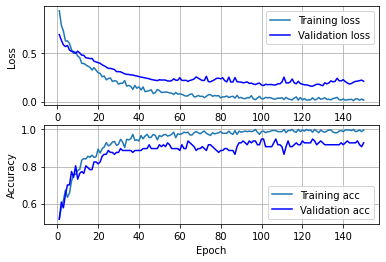

In [25]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Training Accuracy: {round(np.average(acc), 3)}")
print(f"Validation Accuracy: {round(np.average(val_acc), 3)}")

epochs = range(1, len(acc) + 1)
fig, axs = plt.subplots(2, 1)

# plot loss
axs[0].plot(epochs, loss, '-', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid(True)
axs[0].legend(loc='best')
# plot accuracy
axs[1].plot(epochs, acc, '-', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].grid(True)
axs[1].legend(loc='best')

In [27]:
# store model classification result
predicted_labels = model.predict(x_test)
actual_labels = y_test

np.savez(f'data/{feature_type}_test.npz', out_x=predicted_labels, out_y=actual_labels)

print("stored model classification result")

2/2 [==============================] - 0s 10ms/step
stored model classification result


For feature type: mfcc
Accuracy Score: 0.8979591836734694
F1: 0.8995867731230728
Precision: 0.9655172413793104
Youden's Index: 0.8161764705882353
Discriminant Power: 2.601444770760097


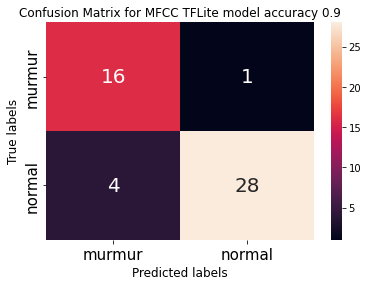

In [28]:
# plot model classification result and other metrics
data = np.load(f'data/{feature_type}_test.npz', allow_pickle=True)

predicted_label, actual_label = data['out_x'], data['out_y']
classes_values = ["murmur", "normal"]
label_predicted = np.argmax(predicted_label, axis=1)
label_actual = np.argmax(actual_label, axis=1)

tn, fp, fn, tp = confusion_matrix(label_actual, label_predicted).ravel()
acc = accuracy_score(label_actual, label_predicted)
report = classification_report(label_actual, label_predicted, output_dict=True)
results = confusion_matrix(label_actual, label_predicted)
precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

x = sensitivity / (1 - sensitivity)
y = specificity / (1 - specificity)

youdens_index = sensitivity - (1 - specificity)
discriminant_power = (math.sqrt(3) / math.pi) * (math.log(x) + math.log(y))

print(f"For feature type: {feature_type}")
print(f"Accuracy Score: {acc}")
print(f"F1: {report['weighted avg']['f1-score']}")
print(f"Precision: {precision}")
print(f"Youden's Index: {youdens_index}")
print(f"Discriminant Power: {discriminant_power}")

ax = plt.subplot()
sns.heatmap(results, annot=True, annot_kws={"size": 20}, ax=ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)
ax.set_title(f'Confusion Matrix for {feature_type.upper()} TFLite model accuracy {round(acc, 2)}')
ax.xaxis.set_ticklabels(classes_values, fontsize=15)
ax.yaxis.set_ticklabels(classes_values, fontsize=15)
plt.savefig(f'images/confusion_matrix_{feature_type}.png', dpi=600)

In [29]:
#inference on saved Keras model 

model_path = f"saved_model/{feature_type}_model"

label_actual, label_predicted = [], []
classes_values = ["murmur", "normal"]
classes = len(classes_values)

load_model = tf.keras.models.load_model(model_path)


for data in enumerate(x_test):
    cepstral_data = np.vstack([data[1]])
    results = load_model.predict(cepstral_data, batch_size=50, verbose=0)
    predicted = classes_values[np.argmax(results)]
    actual = classes_values[np.argmax(y_test[data[0]])]
    label_actual.append(actual)
    label_predicted.append(predicted)


tn, fp, fn, tp = confusion_matrix(label_actual, label_predicted).ravel()
acc = accuracy_score(label_actual, label_predicted)
report = classification_report(label_actual, label_predicted, output_dict=True)
results = confusion_matrix(label_actual, label_predicted)
precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

x = sensitivity / (1 - sensitivity)
y = specificity / (1 - specificity)

youdens_index = sensitivity - (1 - specificity)
discriminant_power = (math.sqrt(3) / math.pi) * (math.log(x) + math.log(y))

print(f"For feature type: {feature_type.upper()} on Keras saved model")
print(f"Accuracy Score: {acc}")
print(f"F1: {report['weighted avg']['f1-score']}")
print(f"Precision: {precision}")
print(f"Youden's Index: {youdens_index}")
print(f"Discriminant Power: {discriminant_power}")


For feature type: MFCC on Keras saved model
Accuracy Score: 0.8979591836734694
F1: 0.8995867731230728
Precision: 0.9655172413793104
Youden's Index: 0.8161764705882353
Discriminant Power: 2.601444770760097


In [30]:
# Convert model to TFlite model

type_of_quantization = "default"
saved_model_dir = f"saved_model/{feature_type}_model"
BATCH_SIZE = 65

data = np.load(dataset_path, allow_pickle=True)

x_data, _ = data['out_x'].astype(np.float32), data['out_y'].astype(np.float32)

def representative_dataset():
    mfcc = tf.data.Dataset.from_tensor_slices(x_data).batch(1)
    for i in mfcc.take(BATCH_SIZE):
        yield [i]


# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)  # path to the SavedModel directory
if type_of_quantization == "Default":
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    # Save the model.
    with open(f'saved_tflite_model/{feature_type}_{type_of_quantization}.tflite', 'wb') as f:
        f.write(tflite_model)

elif type_of_quantization == "int8":
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8
    tflite_model = converter.convert()

    # Save the model.
    with open(f'saved_tflite_model/{feature_type}_{type_of_quantization}.tflite', 'wb') as f:
        f.write(tflite_model)

elif type_of_quantization == "float16":
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    tflite_model = converter.convert()

    # Save the model.
    with open(f'saved_tflite_model/{feature_type}_{type_of_quantization}.tflite', 'wb') as f:
        f.write(tflite_model)


In [31]:
# Inference on TFlite model

model_path = f"saved_tflite_model/{feature_type}_{type_of_quantization}.tflite"

label_actual, label_predicted = [], []
classes_values = ["murmur", "normal"]
classes = len(classes_values)

x_val = x_val.astype(np.float32)

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for data in enumerate(x_val):
    interpreter.set_tensor(input_details[0]['index'], np.vstack([data[1]]))
    interpreter.invoke()

    classes = interpreter.get_tensor(output_details[0]['index'])
    results = np.squeeze(classes)
    predicted = classes_values[np.argmax(results)]
    actual = classes_values[np.argmax(y_val[data[0]])]

    label_actual.append(actual)
    label_predicted.append(predicted)

tn, fp, fn, tp = confusion_matrix(label_actual, label_predicted).ravel()
acc = accuracy_score(label_actual, label_predicted)
report = classification_report(label_actual, label_predicted, output_dict=True)
results = confusion_matrix(label_actual, label_predicted)
precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

x = sensitivity / (1 - sensitivity)
y = specificity / (1 - specificity)

youdens_index = sensitivity - (1 - specificity)
discriminant_power = (math.sqrt(3) / math.pi) * (math.log(x) + math.log(y))

print(f"For feature type: {feature_type.upper()} on TFlite saved model")
print(f"Accuracy Score: {acc}")
print(f"F1: {report['weighted avg']['f1-score']}")
print(f"Precision: {precision}")
print(f"Youden's Index: {youdens_index}")
print(f"Discriminant Power: {discriminant_power}")

For feature type: MFCC on TFlite saved model
Accuracy Score: 0.9587628865979382
F1: 0.9588068306659284
Precision: 0.98
Youden's Index: 0.92008547008547
Discriminant Power: 3.6263093774639947
